In [1]:
import re
from nltk.util import ngrams, pad_sequence, everygrams
from nltk.tokenize import word_tokenize
from nltk.lm import MLE, WittenBellInterpolated
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter

In [2]:
#Training data file
train_data_file = "Original.txt"

In [3]:
#read training data
# , encoding="utf8", errors='ignore'
with open(train_data_file, encoding="utf8", errors='ignore') as f:
    train_text = f.read()

In [4]:
#apply preprocessing (remove text inside square and curly brackets and rem punc)
train_text = re.sub(r"\[.*\]|\{.*\}", "", train_text)
train_text = re.sub(r'[^\w\s]', "", train_text)

In [5]:
#set ngram number
n = 10

In [6]:
#pad and tokenize the data
training_data = list(pad_sequence(word_tokenize(train_text), n, pad_left = True, left_pad_symbol = "<s>"))

In [7]:
#generate ngrams
ngrams = list(everygrams(training_data, max_len = n))
print("Number of ngrams:", len(ngrams))

Number of ngrams: 14205


In [8]:
#build ngram language models
model = WittenBellInterpolated(n)
model.fit([ngrams], vocabulary_text = training_data)
print(model.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 724 items>


In [9]:
#Testing data file
test_data_file = "Originall.txt"

In [10]:
#Read testing data
with open(test_data_file, encoding="utf8", errors='ignore') as f:
    test_text = f.read().lower()
test_text = re.sub(r'[^\w\s]', "", test_text)

In [11]:
#Tokenize and pad the text
testing_data = list(pad_sequence(word_tokenize(test_text), n, pad_left = True, left_pad_symbol = "<s>"))
# print("Length of test data:", len(testing_data))
# print(testing_data)

In [12]:
#assign scores
scores = []
for i, item in enumerate(testing_data[n-1:]):
    s = model.score(item, testing_data[i:i+n-1])
    scores.append(s)

In [13]:
scores_np = np.array(scores)
# print(scores_np)

In [14]:
#set width and height
width = 9
height = np.ceil(len(testing_data)/width).astype("int32")
print("Width, Height:", width, ",", height)

Width, Height: 9 , 159


In [15]:
#copy scores to rectangular blank array
a = np.zeros(width*height)
a[:len(scores_np)] = scores_np
diff = len(a) - len(scores_np)

In [16]:
#apply gaussian smoothing for aesthetics
a = gaussian_filter(a, sigma=1.0)

In [17]:
#reshape to fit rectangle
a = a.reshape(-1, width)

In [18]:
#format labels
labels = [" ".join(testing_data[i:i+width]) for i in range(n-1, len(testing_data), width)]
labels_individual = [x.split() for x in labels]
labels_individual[-1] += [""]*diff
labels = [f"{x:60.60}" for x in labels]

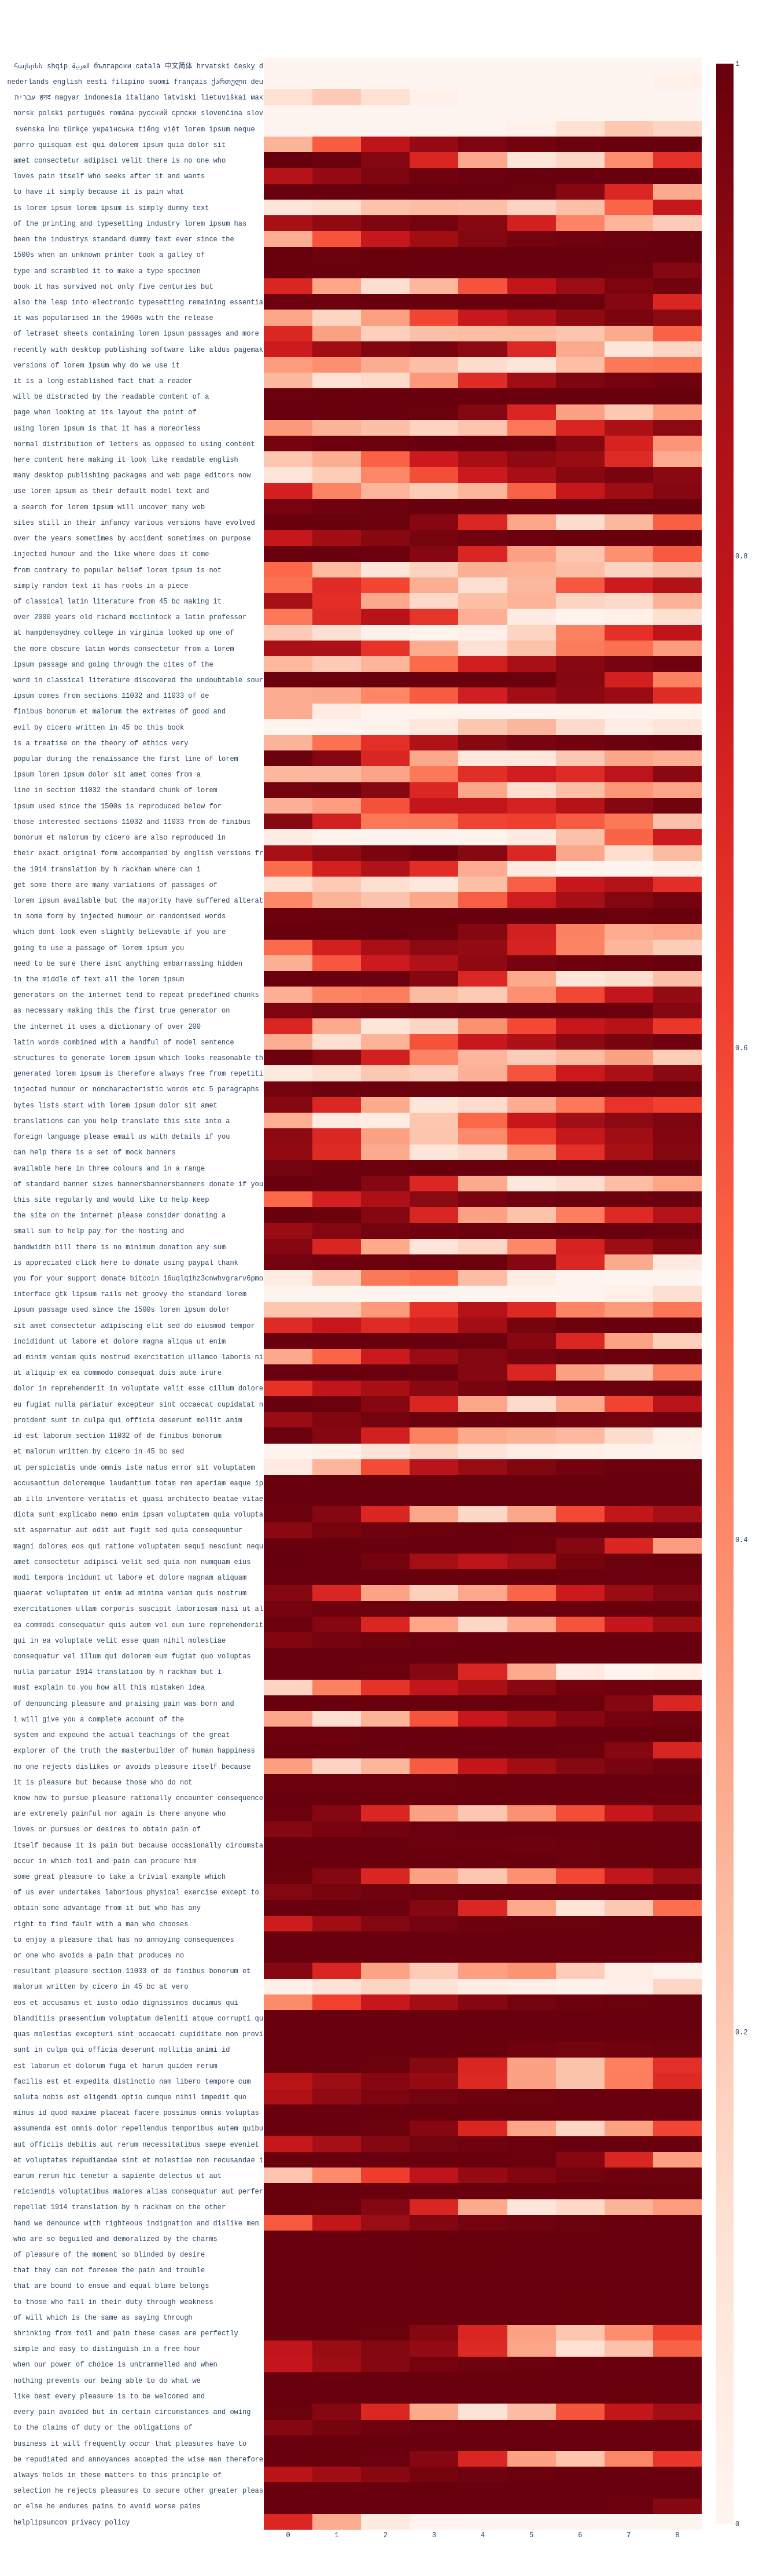

In [19]:
#create heatmap
fig = go.Figure(data=go.Heatmap(z=a, x0=0, dx=1, y=labels, zmin=0, zmax=1, customdata=labels_individual, hovertemplate='%{customdata} <br><b>Score:%{z:.3f}<extra></extra>', colorscale="reds"))
fig.update_layout({"height":height*28, "width":1000, "font":{"family":"Courier New"}})
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show()

In [20]:
arr_sum = np.sum(scores_np)
# print(arr_sum)
# print(len(scores_np))
print("Computed amount of plagiarism is: ", (arr_sum/len(scores_np))*100)

Computed amount of plagiarism is:  70.33928682524088
